last updated: 06/30/2018

# Lightkurve Tutorial
by Ruben Santana

### Introduction
Lightcurves tell us how the brightness of a star changes over time. We can use the lightcurves to find planets by looking for periodic dips in the stars brightness. These dips are caused by the orbitting planet passing infront of their host stars ([transits](https://imgur.com/r/SpaceGifs/43f17Ke)). Therefore, the time in between transits tell us about the period of the planet's orbit.

A more careful analysis of the duration and depth of the dip in brightness will let you know about the relative size and distance of the planet compared to their host star. 

### About tutorial
This tutorial is an adaptation of the [Lightkurve tutorial](https://lightkurve.keplerscience.org/tutorials/section1.html) for beginner programmers wanting to learn how to download and analyze Kepler lightcurve data. The tutorial will be looking at the confirmed planet [Kepler-71b/ KOI-217.01](https://exoplanetarchive.ipac.caltech.edu/cgi-bin/DisplayOverview/nph-DisplayOverview?objname=KOI-217+b&type=CONFIRMED_PLANET). This is one of the many confirmed planets from the Kepler mission. At the end of the tutorial you will know one way to attain the period of a transiting planet. 

### Outline
1. Install lightkurve & Transit periodogram
2. Download planet data & Initial plots
3. Smooth Data: Remove NaN, Outliers, & Trends
4. Finding Period: Periodograms
5. Bin and Phase Fold
6. More to Learn!
7. Additional Resources for Further Research!

## 1. Installation
We will begin by making sure we have all the python packages needed for the tutorial. First, we will install [lightkurve](https://lightkurve.keplerscience.org/install.html) by typing 

`pip install lightkurve`

on the terminal and hitting enter. This should install the package and all the requirements. Next, you will install the box-least square algorithm program (http://adsabs.harvard.edu/abs/2002A%26A...391..369K) by typing in

`pip install git+https://github.com/mirca/transit-periodogram.git`

on the terminal and hitting enter. This will now install all the transit periodogram which will be used to find the period of the planets. If everything installed correctly the following cell should not have any errors. If you still see errors try restarting the kernel by using the tab above labeled **kernel >> restart**.

In [1]:
from lightkurve import KeplerTargetPixelFile, KeplerLightCurveFile
from transit_periodogram import transit_periodogram

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 2. Download Planet Data & Initial Plots
We will choose the target star by either using the star ID, kepler-#, or KOI-#. Next, we will choose how many quarters (of a year) of data we want to download. We will plot these initial quarters to see how they look. The `%%capture` at the top removes the long list of quarter downloads below the cell.

We will plot two kinds of visual data sets TargetPixelFiles (TPFs) and Light Curves (LC). TPFs are stacked images of a single star for every timestamp of data. Each image/timestamp is referred to as a cadence. In the Kepler mission, the pixels were either exposed to light for 5 minutes (short-cadence) or 30 minutes (long-candence). 


When looking at the lightcurves you will notice that the stars brightness is either seen as **SAP_FLUX** or **PDCSAP_Flux**. **SAP_FLUX** is a Simple Aperture Photometry (SAP) lightcurve which basically just sums all the pixels in the aperture. On the other hand, the **PDCSAP_FLUX** Pre-search Data Conditioning SAP (PDCSAP) flux appears to be slightly cleaner because it has long term trends of the star removed from the data using Cotrending Basis Vectors (CBVs).

In [2]:
target = 'KOI-217'

In [3]:
%%capture
#List to hold our TargetPixelFile & LightCurveFile
tpfs = []
lc = []
qRange = [1,17]
for q in range(qRange[0],qRange[1]):
    #Note some quarters are missing, so we'll use Python's try/except to avoid crashing
    try:
        tpfs.append(KeplerTargetPixelFile.from_archive(target, quarter=q))
        lc.append(KeplerLightCurveFile.from_archive(target, quarter=q))
    except:
        continue

In [4]:
#which quarter/index do you want to look all?
quarter = 0

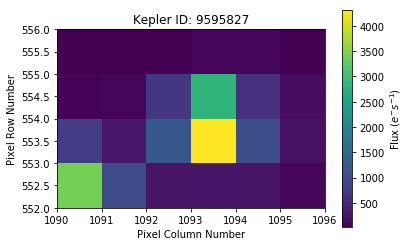

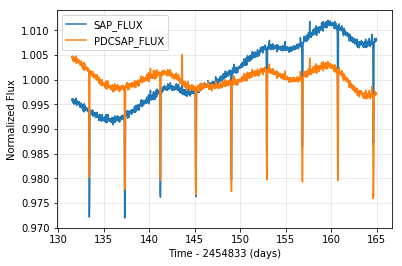

In [5]:
tpfs[quarter].plot()
lc[quarter].plot()

#### Combining Quarters
Now, we will combine all the PDCSAP quarters into one array. You may notice that the first plot has all the quaters centered at a different fluxes, these differences exist because at each quarter the star light gets captured by a different [CCDs](https://www.nasa.gov/mission_pages/kepler/spacecraft/index.html) (charge coupled devices) and each CCD may vary in temperature or in their calibration. Fortunately, lightkurve can adjust to these varations just by adding the `.normalize()` to the end of download command.

In [6]:
%%capture
lcs = KeplerLightCurveFile.from_archive(target, quarter=qRange[0]).PDCSAP_FLUX
lcsNorm = KeplerLightCurveFile.from_archive(target, quarter=qRange[0]).PDCSAP_FLUX.normalize()
for q in range(qRange[0]+1,qRange[1]):
    try:
        lcs = lcs.append(KeplerLightCurveFile.from_archive(target, quarter=q).PDCSAP_FLUX)
        lcsNorm = lcsNorm.append(KeplerLightCurveFile.from_archive(target, quarter=q).PDCSAP_FLUX.normalize())
        
    except:
        continue

Text(0.5,1,'All Quarters Normalized')

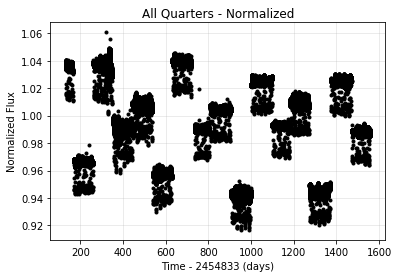

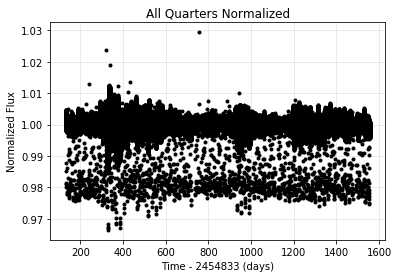

In [7]:
lcs.plot(marker='.',linestyle='none');
plt.title('All Quarters - Normalized')

lcsNorm.plot(marker='.',linestyle='none');
plt.title('All Quarters Normalized')


## 3. Smooth Data: Remove NaN, Outliers, & Trends
In order to prepare the data set for the Box-Least-Square algorigthm a few steps need to take place to smooth the data. We need to remove the NaN values, the outliers, and long-term trends of the star's brightness. Lightkurve accomplishes this with a few functions acted on the TPFs. First, we will use `to_lightcurve()` which counts up the pixels in the aperature and which makes a lightcurve similar to **SAP_FLUX**. Next, we can use `.flatten()` to remove the low frequency trends using scipy’s Savitzky-Golay filter. This will give a result similar to **PDCSAP_FLUX**. Then, we will combine all the quarters and remove all the NaN values using `.remove_nans()` and remove any outliers using`.remove_outliers()`. Outliers in this function as considered to be flux values that are 5 sigmas times the standard deviation away from the mean flux.

In [8]:
#Build the light curve
pipeline_lc = tpfs[0].to_lightcurve().flatten()
for tpf in tpfs:
    pipeline_lc = pipeline_lc.append(tpf.to_lightcurve().flatten())

#Clean the light curve
pipeline_lc = pipeline_lc.remove_nans().remove_outliers()

/home/ruben/anaconda2/lib/python2.7/site-packages/lightkurve/lightcurve.py:251: RuntimeWarning: invalid value encountered in true_divide
  flatten_lc.flux = flatten_lc.flux / trend_signal
/home/ruben/anaconda2/lib/python2.7/site-packages/lightkurve/lightcurve.py:252: RuntimeWarning: invalid value encountered in true_divide
  flatten_lc.flux_err = flatten_lc.flux_err / trend_signal


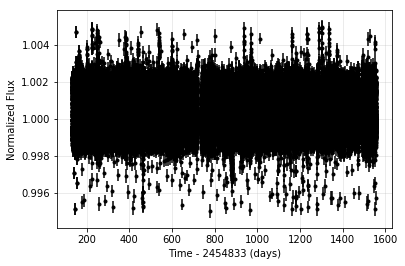

In [9]:
pipeline_lc.plot(fmt='.')

## 4. Finding Period: Periodograms
Now after smoothing out the data we will create a periodogram which will provide a good estimate of the transitting period. Periodograms are created using a fourier transform, which is a mathematical process that takes in continuous time based data and breaks it down to a combination of functions with various frequencies, as seen in the image below. 

![fourier](https://upload.wikimedia.org/wikipedia/commons/6/61/FFT-Time-Frequency-View.png "fast fourier transform")
([wikipedia](https://upload.wikimedia.org/wikipedia/commons/6/61/FFT-Time-Frequency-View.png))

The graph on the left is the continous data which is analagous to our Kepler data. The three sine waves behind the graphs are the functions that are combined to produce a good fit to the original data. Finally, the graph on the right is the periodogram. It shows how much each frequency contributes to reproducing the data model. The greater the peak in the graph the more significant that frequency is in the data. We use this frequency to get an idea of the reoccuring behaivor in the data, for exoplanet research this is the reoccuring transits. Now we just convert the frequency in the periodograms into orbital periods just by using the following equation period = 1/frequency.

![bls](https://johnh2o2.github.io/cuvarbase/_images/bls_transit_diagram_01_00.png)([Hoffman](https://johnh2o2.github.io/cuvarbase/bls.html))

For transits, we generally use a box-like shape as our function with varying frequencies. The box-shaped functions takes into account 4 parameters:

* q - the transit duration as a fraction of the period $t_{trans}/Period$
* $\phi_0$ - the phase offset (from 0)
* $\delta$ - the depth of the transit, difference between out of transit and during transit brightness
* $y_0$ - out of transit brightness

![least_square](https://www.spcforexcel.com/files/images/leastsquare.gif)
([SPCforExcel](https://www.spcforexcel.com/knowledge/root-cause-analysis/linear-regression-part-1))


This box function is used in combination with the least-square model fitting to create a periodogram. Least-square modeling adds up the squares of the smallest distance of each data point to the box function and the lower the sum is the closer the fit is. The goal of the least-square is to correctly find the $\phi_0$ & $\delta$ while the fourier transform/ periodogram focuses more on the period.

Fortunately, all these steps are taken into account by the `transit_periodogram` package and all we have to input is the range of periods we want to look for and the range for duration of transit.

In [10]:
minPer=3
maxPer=5
timeStep = 0.0001  #lower this value if it takes too long
periods = np.arange(minPer, maxPer, timeStep)
durations = np.arange(0.005, 0.3, 0.001) #unit in days
power, _, _, _, _, _, _ = transit_periodogram(time= pipeline_lc.time,
                                              flux=pipeline_lc.flux,
                                              flux_err= pipeline_lc.flux_err,
                                              periods=periods,
                                              durations=durations)
bestPer = periods[np.argmax(power)]

In [11]:
print('Best Fit Period: {} days'.format(bestPer))

Best Fit Period: 3.9051 days


Text(0.5,1,'BLS Periodogram')

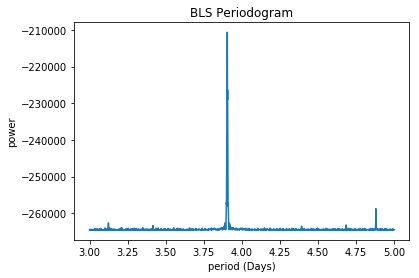

In [12]:
timeStamp = int((maxPer-minPer)/timeStep)

powerTime = np.linspace(minPer,maxPer,timeStamp)
plt.plot(powerTime,power)
plt.xlabel('period (Days)')
plt.ylabel('power')
plt.title('BLS Periodogram')

## 5. Bin and Phase Fold
Now that we have a guess for the period we can fold the data over the period using `.fold()` and then bin the data using `.bin()`. We have some examples of what you may see.

1. The first plot shows what will happen if you choose a period that does not have a transitting planet. The data is very scattered and doesn't show any clear periodic patterns.

2. The second plot shows what you may see if you are looking at the alais of a true transit. You will see that the period choosen is actually half the correct period so you will see the transit however the shape of the transit looks deformed.

3. The last plot shows very convincing signs of being a planet. The transit happens periodic and has a clear dip in brightness at phase 0. The two other dips on the left and right side are caused unfiltered star activity.

(-0.15, 0.15)

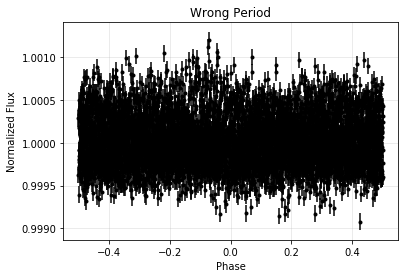

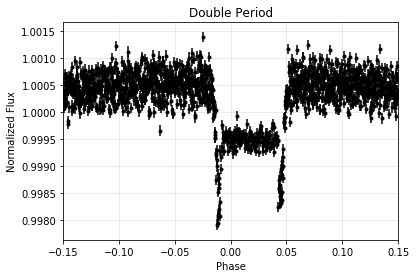

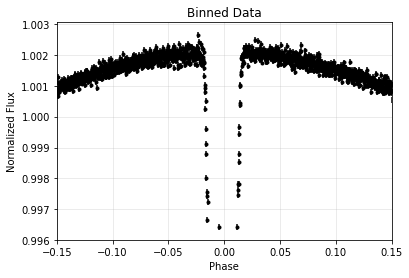

In [13]:
pipeline_lc.fold(period=2.0, phase=0.165).bin().plot(fmt='.');
plt.title('Wrong Period')
# plt.xlim(-0.15,0.15)

pipeline_lc.fold(period=.5*bestPer, phase=0.31).bin().plot(fmt='.');
plt.title('Double Period')
plt.xlim(-0.15,0.15)

pipeline_lc.fold(period=bestPer, phase=0.165).bin().plot(fmt='.');
plt.title('Binned Data')
plt.xlim(-0.15,0.15)

Text(0.5,1,'Phase Fold PDCSAP data')

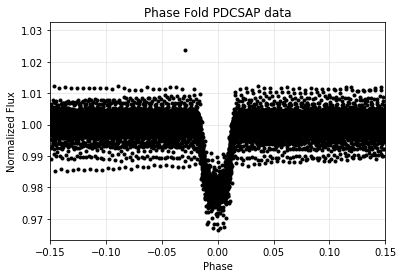

In [14]:
lcsNorm.fold(period=bestPer, phase=0.165).plot(marker='.',linestyle='none');
plt.xlim(-0.15,0.15)
plt.title('Phase Fold PDCSAP data')
# plt.ylim(0.992,1.008)

## More to Learn!
This tutorial is just a glimpse on the ability of Lightkurves. If you have a large interests in transit analyses, I highly recommended looking all the [science with lightkurves](https://lightkurve.keplerscience.org/tutorials/section2.html) and [Systematics correction using lightkurve](https://lightkurve.keplerscience.org/tutorials/section3.html) as they go more in depth on the transit analysis process. They will also teach some other neat techniques to verify the planet by using the TPFs to mask any signals coming from nearby stars. Below is another neat feature which allows you to analyze the lightcurves and the TPFs side by side for each candence.

In [15]:
index = 2
tpfs[index].interact()

Loading BokehJS ...

SEJveChjaGlsZHJlbj0oUGxheSh2YWx1ZT03NDA0LCBkZXNjcmlwdGlvbj11J1ByZXNzIHBsYXknLCBpbnRlcnZhbD0xMCwgbWF4PTExNzczLCBtaW49NzQwNCwgc2hvd19yZXBlYXQ9RmFsc2XigKY=


Output()

## Additional Resources for Further Research
Finding the period is an important step in the research but it is just the beginning. 

After finding the period there are a few more steps that need to be done before confirming the planet. We need to model the transit of the planet and this is generally done by using the algorithm Mandel & Algo ([2002](http://adsabs.harvard.edu/abs/2002ApJ...580L.171M)). The model uses estimates of the planet to star ratio, semi-major axis, period, inclination, etc to make model of what the transit should look like. 

After making an initial model which fits closely to the phase folded dataset, then you will try to optimize your model. Once the optimized and final subtract your optimized model from the original data. This will provide a dataset of residuals will will undergo the entire process again to look for another possible planet. 

Finally, after having optimized models of each possible planet there is a verification process which calculates false positive probabilities for transit signals. 

Below are list of python packages that are useful for the modeling and validation process as well as some other packages that can accomplish the same tasks as the LightKurve Model.
1. For the Mandel & Algo Algorigthm modeling:
    * [BATMAN](https://www.cfa.harvard.edu/~lkreidberg/batman/index.html) - Bad-Ass Transit Model cAlculatioN
    * [PyTransit](https://github.com/hpparvi/PyTransit)

2. For optimizing model:
    * [Scipy.optimize.least_squares](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html)

3. For calculating false positive probabilities for transit signals:
    * [Vespa](https://github.com/timothydmorton/VESPA)

4. Other packages for downloading, smoothing, and finding periods:
    * [Pyketools](https://github.com/KeplerGO/pyke) - downloading and smoothing data
    * [bls](https://github.com/dfm/python-bls) - Box-least square periodogram
